In [1]:
import os

# os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils import Sequence
from keras.utils import to_categorical
import sys


sys.path.append('..')

from preprocess.spectrogram import mel_spectrogram 
from preprocess.wav_helper import trim_audio_to_np_float


2025-10-23 12:45:00.627119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


DATASET_DIR = '../../' + '.tstdata/dataset'
SPEC_SIZE = (128, 376)  # or whatever your function outputs

LABELS = sorted(os.listdir(DATASET_DIR + '/train'))


In [3]:

class AudioDataGenerator(Sequence):
    def __init__(self, data_dir, batch_size=32, input_shape=(128, 128), shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle

        # Collect file paths
        self.filepaths = []
        self.labels = []
        self.label_names = sorted(os.listdir(data_dir))
        self.label_to_idx = {name: i for i, name in enumerate(self.label_names)}

        for label in self.label_names:
            label_dir = os.path.join(data_dir, label)
            for fname in os.listdir(label_dir):
                if fname.lower().endswith(".wav"):
                    self.filepaths.append(os.path.join(label_dir, fname))
                    self.labels.append(self.label_to_idx[label])

        self.indices = np.arange(len(self.filepaths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # number of batches per epoch
        return len(self.filepaths) // self.batch_size

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.filepaths[i] for i in batch_idx]
        batch_labels = [self.labels[i] for i in batch_idx]

        X, y = self.__load_batch(batch_files, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_batch(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_shape, 1), dtype=np.float32)
        y = np.zeros((len(batch_files), len(self.label_names)), dtype=np.float32)

        for i, (path, label_idx) in enumerate(zip(batch_files, batch_labels)):
            try:
                with open(path, 'rb') as f:
                    spec = mel_spectrogram(
                        trim_audio_to_np_float(f.read(), 0, 4, 4)
                    )
                    
                # normalize per-sample
                spec = spec.astype(np.float32)
                spec /= np.max(spec) if np.max(spec) > 0 else 1.0

                if spec.shape != self.input_shape:
                    print("Invalid shape", spec.shape, self.input_shape)
                    continue  # skip invalid shapes

                X[i, :, :, 0] = spec
                y[i, label_idx] = 1.0
            except Exception as e:
                print("Error processing", path, ":", e)

        return X, y


In [4]:
# tf.config.optimizer.set_jit(False)
# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import matplotlib.pyplot as plt
def plot_history(history):
    """
    Plots training and validation accuracy/loss curves from a Keras History object.
    """
    # Extract training metrics
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


In [6]:


model = keras.Sequential([
    keras.layers.InputLayer(shape=(*SPEC_SIZE, 1), dtype=np.float32),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(LABELS), activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1761223503.840552 1466986 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12785 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:04:00.0, compute capability: 8.6


In [7]:
BATCH_SIZE = 32

train_gen = AudioDataGenerator(DATASET_DIR + '/train', batch_size=BATCH_SIZE, input_shape=SPEC_SIZE)
val_gen   = AudioDataGenerator(DATASET_DIR + '/val', batch_size=BATCH_SIZE, input_shape=SPEC_SIZE, shuffle=False)


In [8]:
checkpoint_filepath = '../../.tstdata/ckpt/checkpoint-epoch-{epoch}.model.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    save_freq="epoch"
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_callback]    
)


/venv/main/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8


2025-10-23 12:45:28.280975: I external/local_xla/xla/service/service.cc:163] XLA service 0x74e108010960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-23 12:45:28.281002: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-10-23 12:45:28.420795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-23 12:45:29.007041: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-23 12:45:29.430002: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-23 12:45:29.430116: I external

 1/94 ━━━━━━━━━━━━━━━━━━━━ 33:17 21s/step - accuracy: 0.0625 - loss: 4.7749

I0000 00:00:1761223540.924498 1467169 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4912 - loss: 23.2422

/venv/main/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-23 12:55:55.578700: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-23 12:55:56.533886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_143', 8 bytes spill stores, 8 bytes spill loads



94/94 ━━━━━━━━━━━━━━━━━━━━ 844s 9s/step - accuracy: 0.5768 - loss: 7.3223 - val_accuracy: 0.6454 - val_loss: 1.1956
Epoch 2/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 769s 8s/step - accuracy: 0.6263 - loss: 1.2811 - val_accuracy: 0.6562 - val_loss: 1.0819
Epoch 3/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 754s 8s/step - accuracy: 0.6745 - loss: 0.9951 - val_accuracy: 0.7120 - val_loss: 0.8760
Epoch 4/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 755s 8s/step - accuracy: 0.7211 - loss: 0.9301 - val_accuracy: 0.7405 - val_loss: 0.7960
Epoch 5/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 754s 8s/step - accuracy: 0.7816 - loss: 0.6324 - val_accuracy: 0.7704 - val_loss: 0.7401
Epoch 6/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 754s 8s/step - accuracy: 0.8364 - loss: 0.4600 - val_accuracy: 0.7785 - val_loss: 0.7462
Epoch 7/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 755s 8s/step - accuracy: 0.8949 - loss: 0.2979 - val_accuracy: 0.7758 - val_loss: 0.7401
Epoch 8/8
94/94 ━━━━━━━━━━━━━━━━━━━━ 754s 8s/step - accuracy: 0.9368 - loss: 0.2014 - val_accuracy: 0.8003 - val_loss: 0.8736


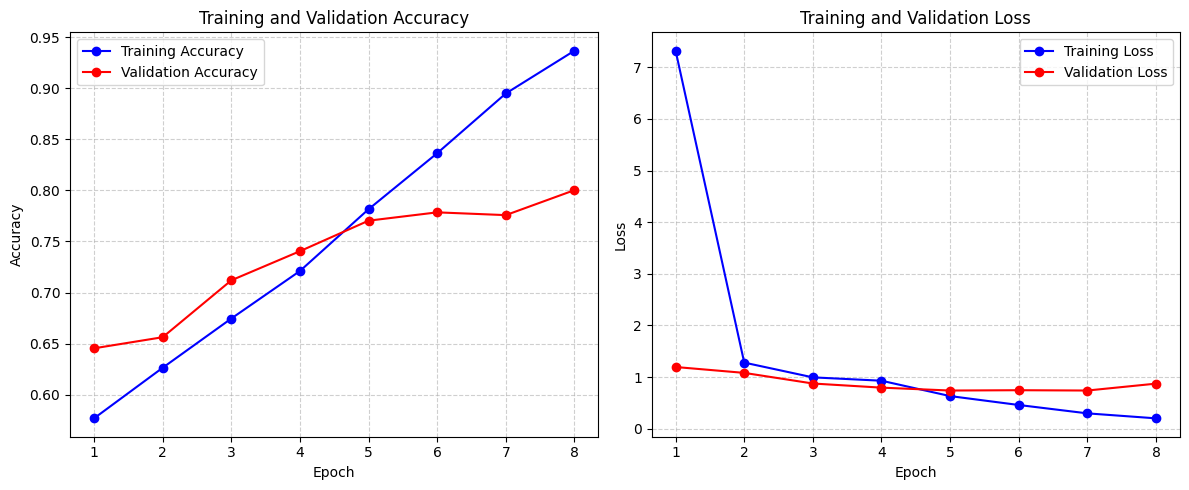

In [9]:
plot_history(history)